$ (y - Xw)^TX=0 $ </br>
y是常数</br>
$ (y - w^TX^T)X=0 $</br>
$ yX - w^TX^TX=0 $</br>
$ w^TX^TX=yX  $</br> 
$ w^T=yX(X^TX)^{-1}  $</br> 
$ w=(yX(X^TX)^{-1})^T  $</br> 
$ w=((X^TX)^{-1})^TX^Ty  $</br> 
$ w=((X^TX)^T)^{-1}X^Ty  $</br> 
$ w=(X^TX)^{-1}X^Ty  $</br> 

# 性质
$ (AB)^T= B^TA^T$</BR>
$ (A+B)^T= A^T+B^T$</BR>
$ (A^T)^T= A $</BR>
$ (A^{-1})^T= (A^T)^{-1} $</BR>
$ (A_1A_2...A_k)^{-1}= A_k^{-1}...A_1^{-1} $</BR>

# 1 线性回归从零开始实现
包括数据流水线 模型 损失函数 和 小批量随机梯度下降优化器

In [1]:
from d2l import torch as d2l
import torch
import random
%matplotlib inline

根据带有噪声的线性模型构造一个人造数据集。使用线性模型参数 $ w = [2,-3.4]^T b = 4.2 $和噪声项$\epsilon$生成数据集及其标签:</br>

$y = Xw + b + \epsilon $

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""

    X = torch.normal(0, 1, (num_examples, len(w)))
    # 均值为0 方差为1的随机数 num_examples样本数 列数是w的长度len(w) size=(num_examples, len(w))

    y = torch.matmul(X, w)+b
    # matmul tensor的乘法

    # 引入随机噪音
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))  # 转换成一列reshape((-1, 1))


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

features中每一行都包含一个二维数据样本 labels每一行都包含一维标签量

In [4]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.5667, 0.9870]) 
label: tensor([1.9939])


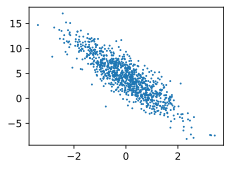

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), s=1)  # pytorch 某些版本中需要从计算图detach出来 才能转换成numpy s散点的面积

定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签尚量作为输入，生成大小为batch_size的小批量


In [22]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)  # 样本
    indices = list(range(num_examples))
    # 这些样本是随机的，没有特定顺序
    random.shuffle(indices)  # shuffle() 方法将序列的所有元素随机排序 打乱下标
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)])
        # yield的函数则返回一个可迭代的 generator（生成器）对象，你可以使用for循环或者调用next()方法遍历生成器对象来提取结果。
        # 在调用生成器函数的过程中，每次遇到 yield 时函数会暂停并保存当前所有的运行信息（保留局部变量），返回yield的值,
        # 并在下一次执行next()方法时从当前位置继续运行，直到生成器被全部遍历完。
        yield features[batch_indices], labels[batch_indices]


batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.1894, -0.0709],
        [-0.6227,  1.4186],
        [ 1.2207,  0.4946],
        [ 1.0107, -0.9331],
        [ 0.8534, -0.4100],
        [ 2.3096,  0.9789],
        [-0.3032,  1.1848],
        [-0.8775, -1.3180],
        [-1.3156,  1.2064],
        [-1.2931, -0.0228]]) 
 tensor([[ 6.8127],
        [-1.8708],
        [ 4.9353],
        [ 9.3899],
        [ 7.2943],
        [ 5.4962],
        [-0.4435],
        [ 6.9369],
        [-2.5430],
        [ 1.6883]])


定义模型

In [24]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w)+b

定义损失函数

In [25]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2  # 此处没除n 不是均值

定义优化算法

In [26]:
def sgd(params, lr, batch_size):  # lr 学习率
    """小批量随机梯度下降"""
    with torch.no_grad():  # 更新时不参与梯度计算
        for param in params:  # w 或 b
            param -= lr * param.grad / batch_size  # 此处求均值
            param.grad.zero_()  # 手动梯度归零 下次计算时不会与上次相关了

定义初始化参数模型

In [39]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# 重新训练需要 在运行一次  否则梯度会叠加

训练过程

In [40]:
lr = 0.5  # 学习率
num_epochs = 3
net = linreg  # 模型
loss = squared_loss  # 损失

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)   # x y的小批量损失 l是长为批量大小的向量
        # l的形状是(batch_size,1) 而不是一个标量 l中所有元素被加到
        # 并以此计算关于[w,b]的参数
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)  # 评价
        print(f'epoch{epoch+1},loss {float(train_l.mean()):f}')

epoch1,loss 0.000057
epoch2,loss 0.000059
epoch3,loss 0.000055


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [41]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'w的估计误差：{true_b-b}')

w的估计误差：tensor([-0.0003, -0.0017], grad_fn=<SubBackward0>)
w的估计误差：tensor([-0.0008], grad_fn=<RsubBackward1>)


# 1线性回归的简洁实现
通过使用深度学习框架来简洁地实现线性回归模型生成数据集

In [1]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

调用框架中现有的API来读取数据

In [2]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    # 将xy转化成TensorDataset 可调用DataLoader每次从中调取batch_size shuffle随机
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-0.0376,  0.9000],
         [ 0.7740, -0.2799],
         [-0.3145, -2.1306],
         [ 0.9494,  0.4880],
         [-1.6581, -0.5474],
         [ 0.8009, -0.6803],
         [ 1.5104,  0.4725],
         [-0.2742,  1.6255],
         [-0.6010,  0.3288],
         [-0.1958,  0.2760]]),
 tensor([[ 1.0739],
         [ 6.7094],
         [10.8181],
         [ 4.4452],
         [ 2.7512],
         [ 8.1112],
         [ 5.6188],
         [-1.8796],
         [ 1.8804],
         [ 2.8816]])]

使用框架与定义好的层

In [3]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1)) #(输入维度，输出维度)

初始化参数模型

In [4]:
net[0].weight.data.normal_(0, 0.01)  # net[0] nn.Linear
net[0].bias.data.fill_(0)

tensor([0.])

计算均方误差使用MSELoss类 平方$L_2$范数

In [5]:
loss = nn.MSELoss()

实例化SGD实例

In [6]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

训练过程代码与我们从零开始实现时所做的非常相似

In [7]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad() #梯度清0
        l.backward()
        trainer.step()  # 模型更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000236
epoch 2, loss 0.000104
epoch 3, loss 0.000104
